# **1. Kết nối với google drive**

In [ ]:
# kết nối với gg drive
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/NLP 4+1/Cuối kỳ/')
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1bs2wermM-w1hKEOcHyv-UmLHY5iag5cm/NLP 4+1/Cuối kỳ'

# **2. Install và import các thư viện cần thiết**

In [ ]:
!pip install keras_preprocessing --quiet
!pip install pyvi --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.4 MB/s eta 0:00:00


In [ ]:
import re
import time
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

from pyvi import ViTokenizer

from keras_preprocessing.text import Tokenizer

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
import pickle

# saving
def save_file(data, path):
    with open(path + '.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
def load_file(path):
    with open(path, 'rb') as handle:
        data = pickle.load(handle)
    return data

# **3. Set các biến cục bộ và load dữ liệu**

In [ ]:
MAXLEN_QUESTION = 15
MAXLEN_ANSWER = 15
EPOCHS = 100
BATCH_SIZE = 32
path_data = './dataset/'
path_pre_trained = './pre-trained/LSTM + Attention (100 epoch)/'

In [ ]:
df_train = pd.read_csv(path_data + 'train.csv')
df_train

,question,answer
0,có thưởng tết không,có
1,quê mày ở đâu,đà_nẵng
2,bạn thích chơi môn thể_thao nào,mình thích chơi bóng_đá
3,gia_đình cậu có sống ở thành_phố hồ chí minh k...,gia_đình tớ đang ở cùng tớ
4,nếu có người_yêu thì việc đầu_tiên bạn làm là gì,mình sẽ dẫn người_yêu đi xem phim
...,...,...
10743,xung quang trọ bạn như thế_nào,nhiều của hàng tiện_lợi nhưng không có chợ
10744,khi nào đi đá cậu rủ tớ tham_gia được không,được á tớ sẽ mời cậu tham_gia chơi chung cho vui
10745,bạn tên gì vậy,mình tên vũ
10746,lương cao không,không cao lắm


# **4. Xử lý dữ liệu**

## ***4.1 Thêm ký tự đầu câu và kết thúc câu cho đầu ra***

In [ ]:
df_train['answer'] = df_train['answer'].apply(lambda text: f'<s> {text} </s>')
df_train

,question,answer
0,có thưởng tết không,<s> có </s>
1,quê mày ở đâu,<s> đà_nẵng </s>
2,bạn thích chơi môn thể_thao nào,<s> mình thích chơi bóng_đá </s>
3,gia_đình cậu có sống ở thành_phố hồ chí minh k...,<s> gia_đình tớ đang ở cùng tớ </s>
4,nếu có người_yêu thì việc đầu_tiên bạn làm là gì,<s> mình sẽ dẫn người_yêu đi xem phim </s>
...,...,...
10743,xung quang trọ bạn như thế_nào,<s> nhiều của hàng tiện_lợi nhưng không có chợ...
10744,khi nào đi đá cậu rủ tớ tham_gia được không,<s> được á tớ sẽ mời cậu tham_gia chơi chung c...
10745,bạn tên gì vậy,<s> mình tên vũ </s>
10746,lương cao không,<s> không cao lắm </s>


# ***4.2 Khởi tạo bộ tokenizer***

In [ ]:
questions = list(df_train['question'].values)
answers = list(df_train['answer'].values)

In [ ]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(questions + answers)

# save
save_file(tokenizer, path_pre_trained + 'tokenizer') 

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f'Vocabulary size : {VOCAB_SIZE}')

Vocabulary size : 5471


# ***4.3 Tokenizer dữ liệu cho Encoder (questions)***

In [ ]:
# encoder
tokenized_questions = tokenizer.texts_to_sequences(questions)
encoder_inp = pad_sequences(tokenized_questions, maxlen=MAXLEN_QUESTION, padding='post')

print(encoder_inp.shape)
print(questions[0])
print(tokenized_questions[0])
print(encoder_inp[0])

(10748, 15)
có thưởng tết không
[5, 1412, 61, 4]
[   5 1412   61    4    0    0    0    0    0    0    0    0    0    0
    0]


# ***4.3 Tokenizer dữ liệu cho Decoder (answer)***

In [ ]:
# decoder
tokenized_answers = tokenizer.texts_to_sequences(answers)
decoder_inp = pad_sequences(tokenized_answers, maxlen=MAXLEN_ANSWER, padding='post')

print(decoder_inp.shape)
print(answers[0])
print(tokenized_answers[0])
print(decoder_inp[0])

(10748, 15)
<s> có </s>
[1, 5, 2]
[1 5 2 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
    
padded_answers = pad_sequences(tokenized_answers, maxlen=MAXLEN_ANSWER, padding='post')
decoder_final_output = to_categorical(padded_answers, VOCAB_SIZE)

print(decoder_final_output.shape)
print(tokenized_answers[0])
print(padded_answers[0])
print(decoder_final_output[0])

(10748, 15, 5471)
[5, 2]
[5 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
encoder_inp.shape, decoder_inp.shape, decoder_final_output.shape

((10748, 15), (10748, 15), (10748, 15, 5471))

# **3. Xây dựng và training model**

In [ ]:
#encoder part start
enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(VOCAB_SIZE, 256, mask_zero=True)(enc_inputs)
enc_ouputs, enc_state_h, enc_state_c = LSTM(256, return_state=True, return_sequences=True)(enc_embedding)

#decoder part start
dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE, 256, mask_zero=True)(dec_inputs)
dec_lstm = LSTM(256, return_state=True, return_sequences=True)
dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=[enc_state_h, enc_state_c])

#Attention layer (query,value)
attn_layer = Attention()
attention_context = attn_layer([dec_outputs, enc_ouputs])

decoder_output = Concatenate(axis=-1)([dec_outputs,attention_context])

dense1 = Dense(512,activation='relu')
decoder_output = dense1(decoder_output)

decoder_softmax = Dense(VOCAB_SIZE,activation='softmax')
output = decoder_softmax(decoder_output)

In [ ]:
model = Model([enc_inputs, dec_inputs], output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    1400576     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1400576     ['input_2[0][0]']                
                                                                                              

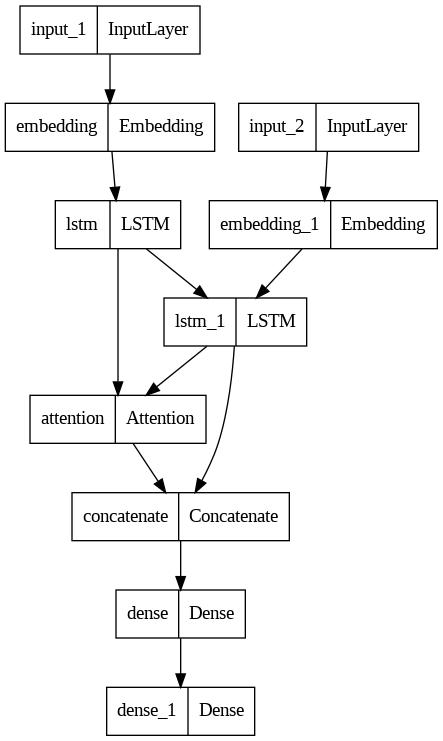

In [ ]:
plot_model(model)

In [ ]:
def generate_batch(encoder_inp_data, decoder_inp_data, padded_answer_data, batch_size = 32):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(encoder_inp_data), batch_size):
            encoder_input = encoder_inp_data[j:j+batch_size]
            decoder_input = decoder_inp_data[j:j+batch_size]
            decoder_answer = to_categorical(padded_answer_data[j:j+batch_size],VOCAB_SIZE)

            yield([encoder_input, decoder_input], decoder_answer)

In [ ]:
t0 = time.time()
history = model.fit(generate_batch(encoder_inp, decoder_inp, padded_answers, batch_size = BATCH_SIZE),
                    steps_per_epoch = len(encoder_inp)//BATCH_SIZE,
                    epochs = EPOCHS)
time_train = time.time() - t0

# save
model.save(path_pre_trained + 'model_LSTM_Attention.h5')

Epoch 1/100
335/335 [==============================] - 38s 64ms/step - loss: 5.1525
Epoch 2/100
335/335 [==============================] - 8s 24ms/step - loss: 4.6153
Epoch 3/100
335/335 [==============================] - 9s 27ms/step - loss: 4.3774
Epoch 4/100
335/335 [==============================] - 9s 27ms/step - loss: 4.1819
Epoch 5/100
335/335 [==============================] - 8s 24ms/step - loss: 3.9904
Epoch 6/100
335/335 [==============================] - 9s 27ms/step - loss: 3.8251
Epoch 7/100
335/335 [==============================] - 9s 27ms/step - loss: 3.6750
Epoch 8/100
335/335 [==============================] - 8s 23ms/step - loss: 3.5334
Epoch 9/100
335/335 [==============================] - 9s 28ms/step - loss: 3.4000
Epoch 10/100
335/335 [==============================] - 10s 30ms/step - loss: 3.2746
Epoch 11/100
335/335 [==============================] - 8s 23ms/step - loss: 3.1589
Epoch 12/100
335/335 [==============================] - 9s 27ms/step - loss: 3.0337

In [ ]:
val_compare = {
    'loss_history': history.history['loss'],
    'time_train': time_train
}

# save
save_file(val_compare, path_pre_trained + 'val_compare')

In [ ]:
def make_inference_models():
    print('Inference encoder:')
    enc_model = Model(inputs=enc_inputs, outputs=[enc_ouputs, enc_state_h, enc_state_c])
    enc_model.summary()

    gen_dec_value_input = Input(shape=(None,256))
    gen_dec_input_h = Input(shape=(256,))
    gen_dec_input_c = Input(shape=(256,))

    gen_decoder_output,gen_decoder_h,gen_decoder_c = dec_lstm(dec_embedding, initial_state=[gen_dec_input_h, gen_dec_input_c])

    gen_attention_context = attn_layer([gen_decoder_output,gen_dec_value_input])
    gen_decoder_output = Concatenate(axis=-1)([gen_decoder_output,gen_attention_context])

    gen_decoder_output = dense1(gen_decoder_output)
    gen_decoder_output = decoder_softmax(gen_decoder_output)
    
    dec_model = Model(
        inputs  = [dec_inputs]  +[gen_dec_value_input,gen_dec_input_h,gen_dec_input_c],
        outputs = [gen_decoder_output] + [gen_decoder_h,gen_decoder_c])
    print('\n\nInference decoder:')
    dec_model.summary()
    
    return enc_model, dec_model

enc_model, dec_model = make_inference_models()

# save
enc_model.save(path_pre_trained + 'enc_model.h5')
dec_model.save(path_pre_trained + 'dec_model.h5')

Inference encoder:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         1400576   
                                                                 
 lstm (LSTM)                 [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,925,888
Trainable params: 1,925,888
Non-trainable params: 0
_________________________________________________________________


Inference decoder:
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)            

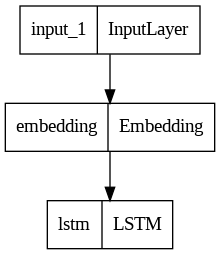

In [ ]:
plot_model(enc_model)

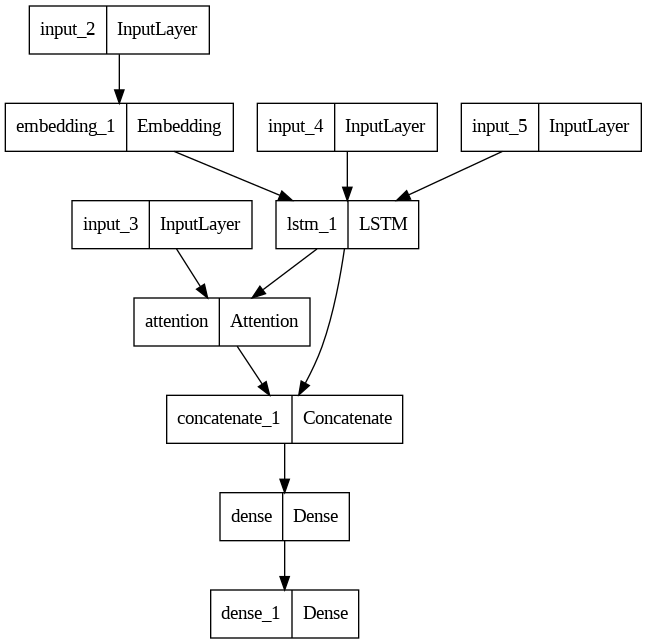

In [ ]:
plot_model(dec_model)

In [ ]:
def preprocess(text):
    text = text.lower()                                                 # chuyển về chữ thường
    text = re.sub(r'[!“”"’#$%&\()*+,./:;<=>?@[\]^_`{|}~]', "", text)    # loại bỏ kí tự đặt biệt
    text = ViTokenizer.tokenize(text)                                   # word segmentation
    return text

def str_to_tokens(sentence):
    words = preprocess(sentence)
    tokens_list = tokenizer.texts_to_sequences([words])
    return pad_sequences(tokens_list, maxlen=MAXLEN_QUESTION,padding='post')

def bot_give_answer(question):
    values,h,c = enc_model.predict(str_to_tokens(question), verbose=0)
    empty_target_seq = np.zeros((1,1))
    empty_target_seq[0,0] = tokenizer.word_index['<s>']
    stop_condition = False
    generated_answer = ''

    while not stop_condition:
        dec_outputs, h_state,c_state = dec_model.predict([empty_target_seq]+[values,h,c], verbose=0)
        sampled_word_index = np.argmax(dec_outputs[0,-1, :])
        sampled_word = tokenizer.index_word[sampled_word_index]
        
        if sampled_word != '</s>':
            generated_answer += f'{sampled_word} '

        if sampled_word == '</s>' or len(generated_answer.split()) > MAXLEN_ANSWER:
            stop_condition = True
        empty_target_seq = np.zeros((1,1))
        empty_target_seq[0,0] = sampled_word_index
        h,c = h_state,c_state

    return generated_answer.strip()
bot_give_answer('bạn có người yêu chưa')

'có'